In [197]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}
# loadmap = {'cuda:0': 'cpu'}

# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import utils
from GAN import GAN as gan

import matplotlib.pyplot as plt
import pandas as pd
import datetime
from tqdm import tqdm_notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using GAN to generate Financial Time Series

## Reproducing the properties of a single Time Serie

We will first try to implement a GAN that will be able to generate time series that have the same properties as the VIX Index. For this we use Quandl API to generate the data and then implement the networks using Pytorch.

### Download the VIX Index between 2014 and 2019

In [3]:
# VIX Index from 2014
VIX = pd.read_csv("VIX.csv",index_col=0, parse_dates=True, dayfirst=True)
VIX['VIX'] = VIX['VIX'].astype('float')

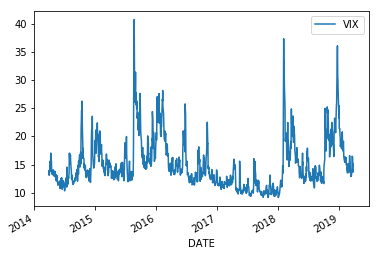

In [4]:
VIX.plot()

As a pre-processing, we want to remove two dependancies of the data:
* Index level dependancy: for this we consider the log-return of the index level
* Time difference between the successive dates: to remove this effect we annualize all returns

So the new time series we will consider takes the form:

$$
X_t = \frac{365}{\Delta t} \text{log}(\frac{VIX_t}{VIX_{t-1}})
$$

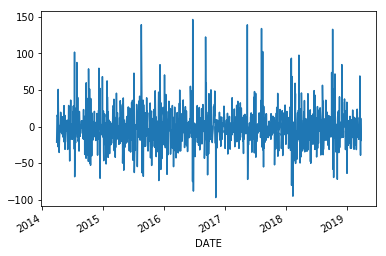

In [5]:
utils.get_data('VIX.csv', array=False).plot()

### Implementing the batch generator

Our aim is to generates sequences of data with the same behaviour as the annualized log returns of the VIX Index. For this we assume that the time serie follow an underlying distribution $p_\theta$ that we want to approximate with a GAN. During the training the network will need real samples from this distribution, and in order to avoid feeding it with the same data at each step we will only provide it random sequences extracted from the true realization.

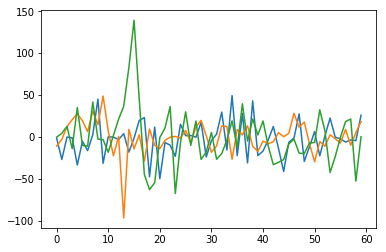

In [7]:
VIX = utils.get_data('VIX.csv')
batch = utils.generate_batch(VIX, 60, 3)
plt.plot(batch.numpy().T)

Now we can define the Generator and the Discriminator of the GAN.

step 0: discriminator: 1.108e+02, generator: -8.657e+01


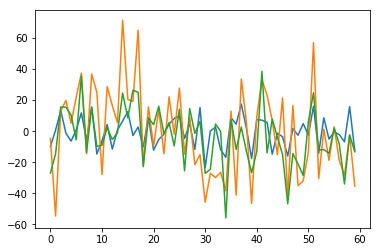

step 100: discriminator: 9.534e+01, generator: -5.932e+01


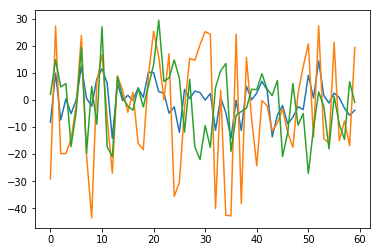

step 200: discriminator: 6.618e+01, generator: -2.875e+01


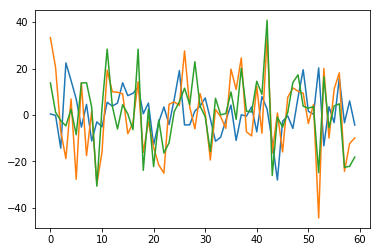

step 300: discriminator: 1.993e+01, generator: -7.699e+00


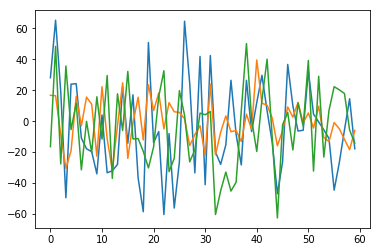

step 400: discriminator: 2.356e+01, generator: -4.273e+00


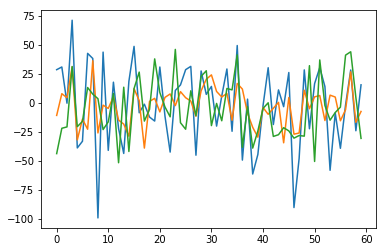

step 500: discriminator: 2.230e+01, generator: -7.957e+00


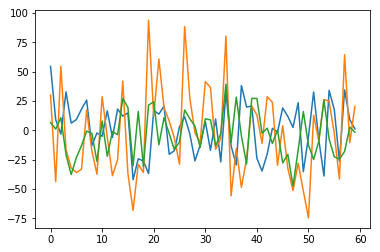

step 600: discriminator: 2.388e+01, generator: -1.391e+01


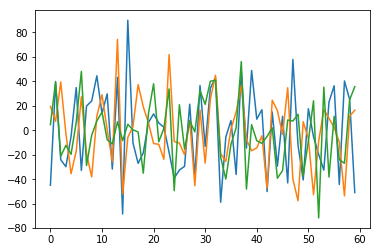

step 700: discriminator: 8.021e+01, generator: -3.768e+01


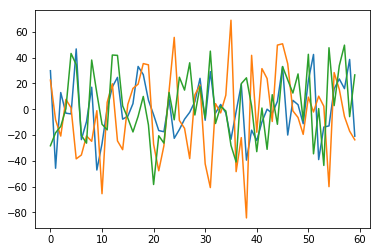

step 800: discriminator: 6.755e+01, generator: -2.930e+01


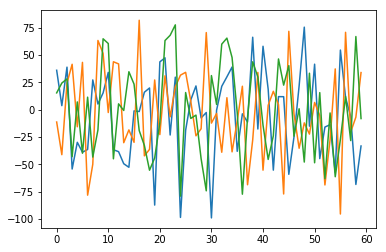

step 900: discriminator: 4.705e+01, generator: -1.435e+01


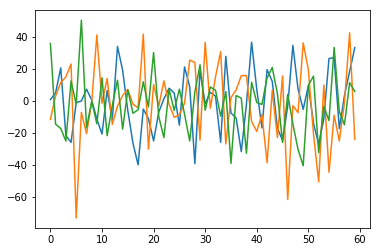

step 1000: discriminator: 3.900e+01, generator: -2.761e+01


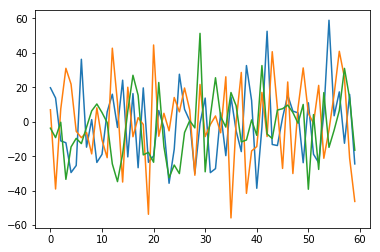

step 1100: discriminator: 3.734e+01, generator: -2.346e+01


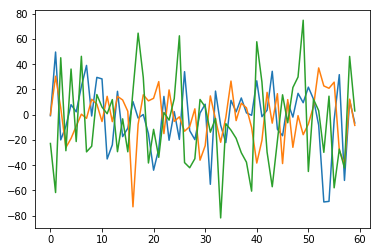

step 1200: discriminator: 3.414e+01, generator: -1.646e+01


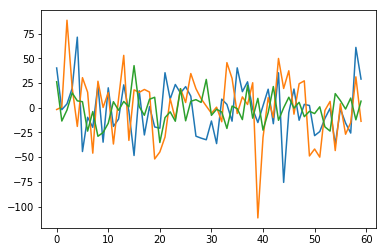

step 1300: discriminator: 2.367e+01, generator: -2.103e+01


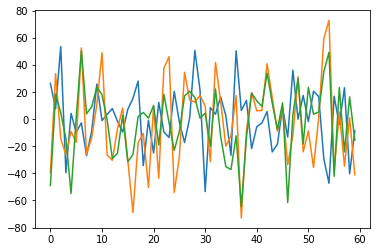

step 1400: discriminator: 3.266e+01, generator: -5.654e+00


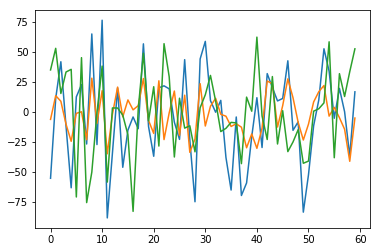

step 1500: discriminator: 1.832e+01, generator: -5.581e+00


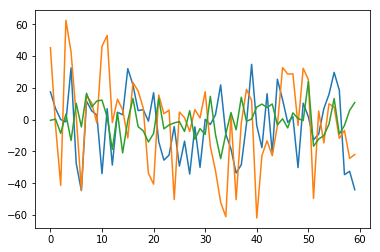

step 1600: discriminator: 1.368e+01, generator: -1.233e+01


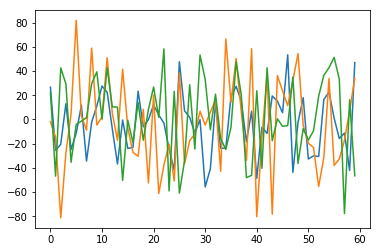

step 1700: discriminator: 9.051e+00, generator: -1.133e+01


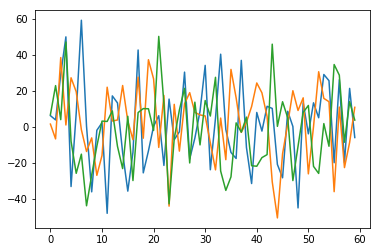

step 1800: discriminator: 8.052e+00, generator: -8.640e+00


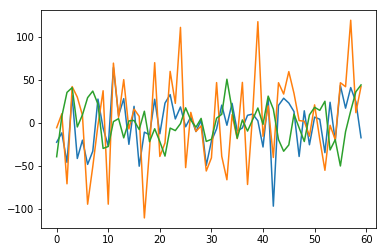

step 1900: discriminator: 4.996e+00, generator: -1.540e+01


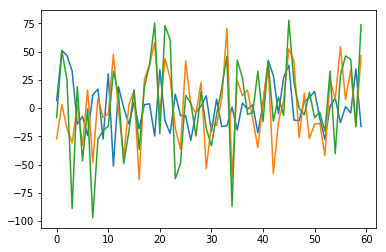

In [10]:
gan(VIX, window= 60, TRAIN_RATIO=10, N_ITER=2000, BATCHLEN=100,
    WDTH_G=100, DPTH_G=2, WDTH_D= 100, DPTH_D=2, PRIOR_N=10,
    PRIOR_STD=400, frame=100, batchlen_plot=3)

# Pre-Trained models

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 60, 'frame': 500, 'frame_plot': 200, 'is_notebook': False, 'batchlen_plot': 10, 'Generator': <class 'Lin_GAN.Generator'>, 'Discriminator': <class 'Lin_GAN.Discriminator'>, 'save_model': True, 'save_name': 'Lin_G_581130543', 'plot': False, 'N_ITER': 2001, 'TRAIN_RATIO': 10, 'BATCHLEN': 100, 'generator_args': {'PRIOR_N': 1, 'PRIOR_STD': 1.0, 'WDTH': 10, 'DPTH': 3}, 'discriminator_args': {'WDTH': 1000, 'DPTH': 10}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9)}


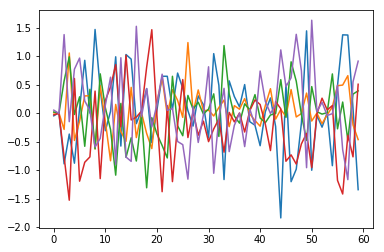

In [9]:
from Lin_GAN import *
from Lin_GAN import Generator as LG
from Lin_GAN import Discriminator as LD
name = 'Lin_G_581130543'
G, D, param_name = utils.load_models(name, LG, LD)
print(param_name)
plt.plot(G.generate(5).detach().numpy().T)
plt.show()

In [207]:
import os
available_param = os.listdir('Parameters')
name_list = []
for x in available_param:
    name_list.append(x[:-3])

In [208]:
gen = {}
param = {}
disc = {}
for name in tqdm(name_list):
    try:
        G, D, param_name = utils.load_models(name, LG, LD)
        gen[name] = G
        disc[name] = D
        param[name] = param_name
    except:
        print('file {} not found'.format(name))
        pass

file CG_241247271 not found
file CG_495999299 not found
file CG_627409447 not found
file Lin_G_173909855 not found
file Lin_G_828670679 not found
file RGAN_3971623 not found
file RGAN_775888731 not found



In [209]:
name_window = {'3M': [], '6M': [], 'Y': []}
for name in param.keys():
    wdw = param[name]['window']
    if wdw == 60:
        name_window['3M'].append(name)
    elif wdw == 125:
        name_window['6M'].append(name)
    elif wdw == 250:
        name_window['Y'].append(name)
    else:
        print('Unexpected window: {}'.format(wdw))
print([(key, len(name_window[key])) for key in name_window.keys()])

[('3M', 180), ('6M', 173), ('Y', 145)]


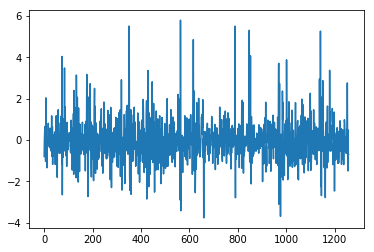

In [210]:
data = get_data('VIX.csv')
data = (data - data.mean())/data.std()
plt.plot(data)
plt.show()

In [211]:
n0, l0 = utils.get_KL_div_list(data, '3M', 100, name_window, LG, LD)
n1, l1 = utils.get_KL_div_list(data, '6M', 100, name_window, LG, LD)
n2, l2 = utils.get_KL_div_list(data, 'Y', 100, name_window, LG, LD)


 37%|██████████████████████████████▏                                                  | 67/180 [00:27<00:50,  2.25it/s]


 75%|████████████████████████████████████████████████████████████                    | 135/180 [00:50<00:12,  3.53it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:05<00:00,  3.37it/s]

 13%|██████████▎                                                                      | 22/173 [00:26<02:50,  1.13s/it]


 52%|██████████████████████████████████████████▏                                      | 90/173 [01:44<01:37,  1.18s/it]


 91%|█████████████████████████████████████████████████████████████████████████       | 158/173 [03:12<00:21,  1.44s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [03:35<00:00,  1.59s/it]

 36%|█████████████████████████████                                                    | 52/145 [02:50<05:07,  3.31s/it]


 83%|██████████████████████████████████████████████████████████████████▏             | 120/145 [06:28<01:19,  3.18s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [07:49<00:00,  3.11s/it]


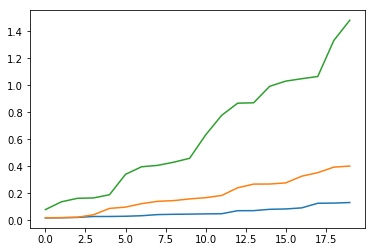

In [212]:
order_60 = np.argsort(l0)
order_125 = np.argsort(l1)
order_250 = np.argsort(l2)
plt.plot(np.sort(l0)[:20])
plt.plot(np.sort(l1)[:20])
plt.plot(np.sort(l2)[:20])

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 60, 'frame': 20, 'frame_plot': 50, 'is_notebook': False, 'batchlen_plot': 100, 'Generator': <class 'DCGAN.Generator'>, 'Discriminator': <class 'DCGAN.Discriminator'>, 'N_ITER': 500, 'TRAIN_RATIO': 1, 'BATCHLEN': 10, 'generator_args': {'PRIOR_N': 200, 'PRIOR_STD': 1.0, 'WDTH': 500, 'DPTH': 5}, 'discriminator_args': {'WDTH': 50, 'DPTH': 1}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9), 'time_max': 600, 'save_model': True, 'save_name': 'Lin_G_224285413', 'plot': False}


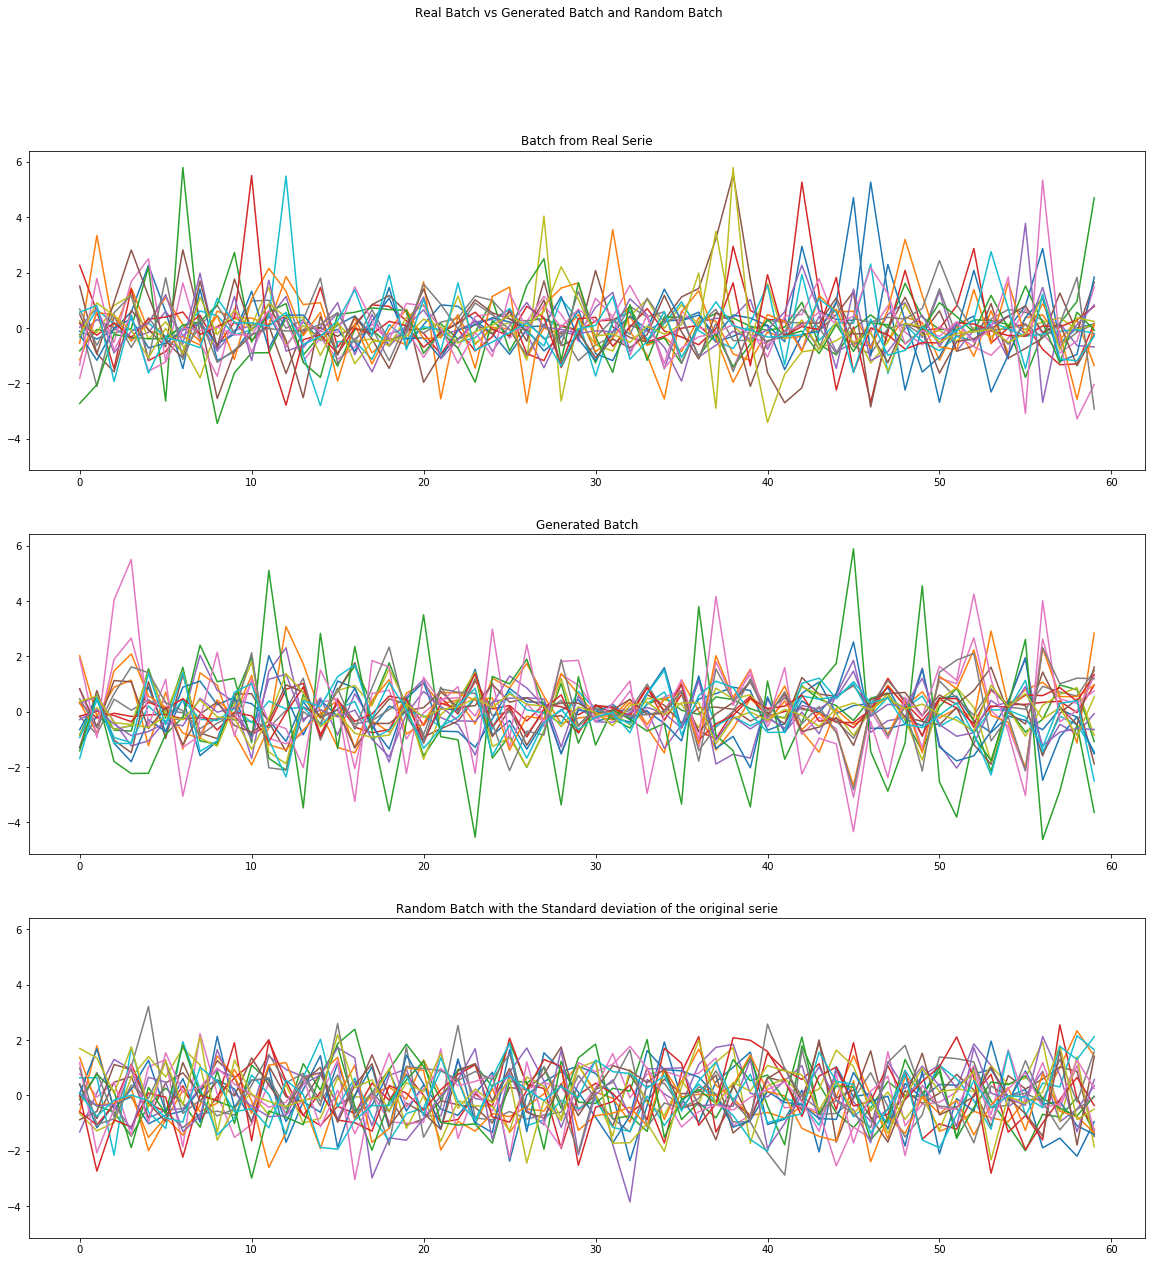

In [219]:
name_best = n0[order_60[2]]
utils.compare_plots(name_best, data, 20, 60, LG, LD)

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 125, 'frame': 20, 'frame_plot': 50, 'is_notebook': False, 'batchlen_plot': 100, 'Generator': <class 'DCGAN.Generator'>, 'Discriminator': <class 'DCGAN.Discriminator'>, 'N_ITER': 500, 'TRAIN_RATIO': 1, 'BATCHLEN': 10, 'generator_args': {'PRIOR_N': 10, 'PRIOR_STD': 10.0, 'WDTH': 1000, 'DPTH': 20}, 'discriminator_args': {'WDTH': 50, 'DPTH': 2}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9), 'time_max': 600, 'save_model': True, 'save_name': 'Lin_G_303541266', 'plot': False}


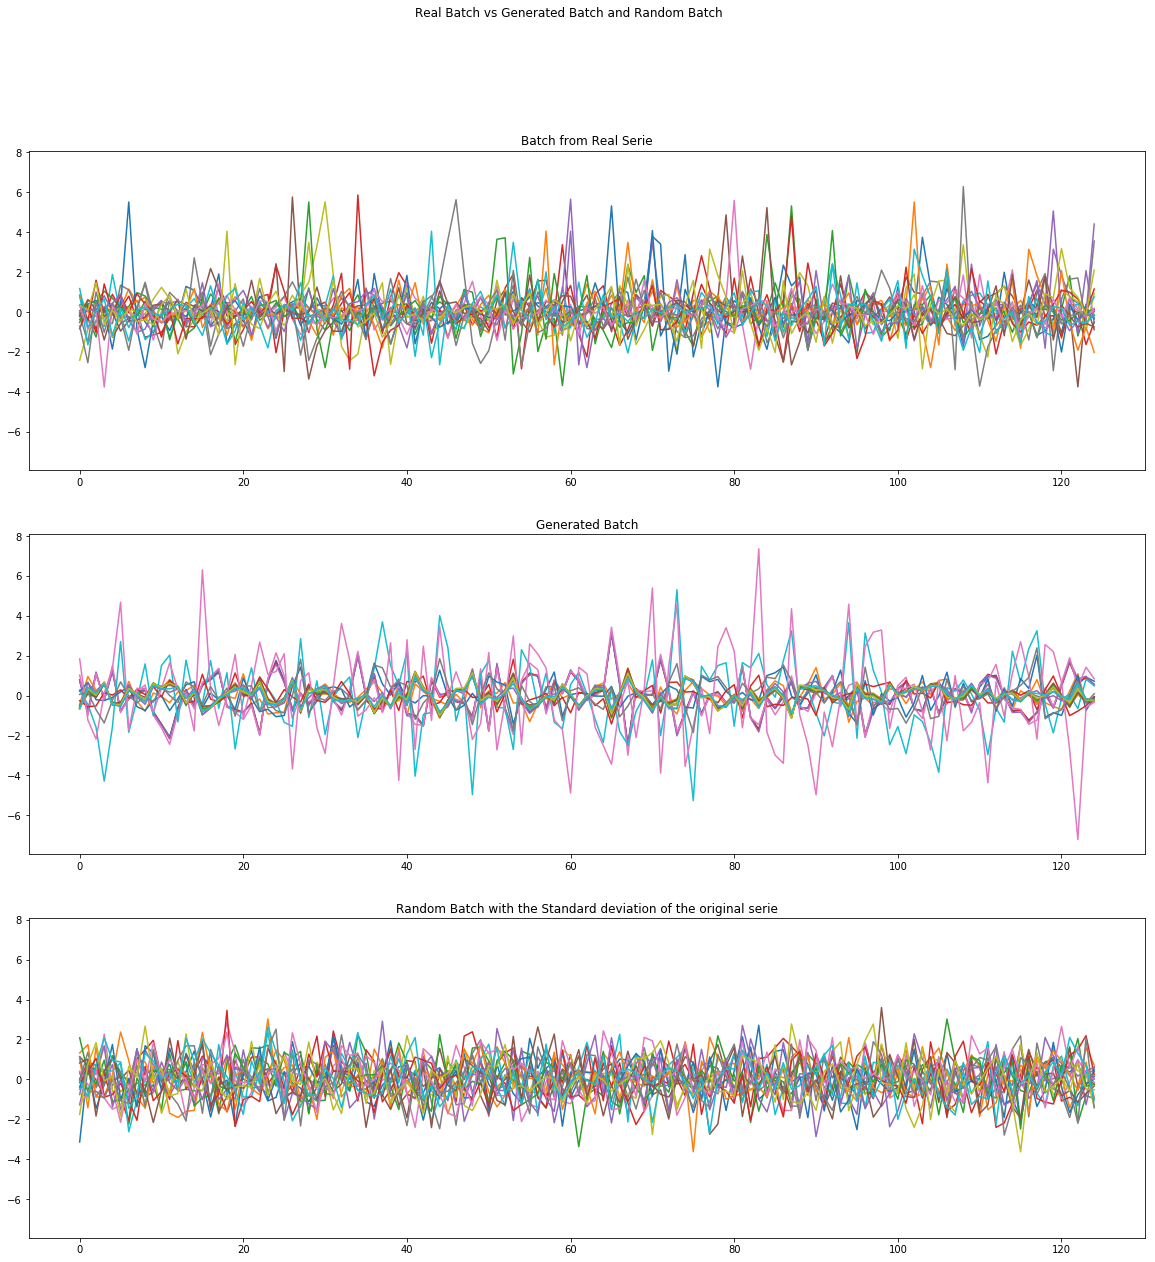

In [220]:
name_best = n1[order_125[1]]
utils.compare_plots(name_best, data, 20, 125, LG, LD)

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 250, 'frame': 20, 'frame_plot': 50, 'is_notebook': False, 'batchlen_plot': 100, 'Generator': <class 'DCGAN.Generator'>, 'Discriminator': <class 'DCGAN.Discriminator'>, 'N_ITER': 500, 'TRAIN_RATIO': 1, 'BATCHLEN': 50, 'generator_args': {'PRIOR_N': 1, 'PRIOR_STD': 10.0, 'WDTH': 500, 'DPTH': 5}, 'discriminator_args': {'WDTH': 10, 'DPTH': 3}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9), 'time_max': 600, 'save_model': True, 'save_name': 'Lin_G_84760957', 'plot': False}


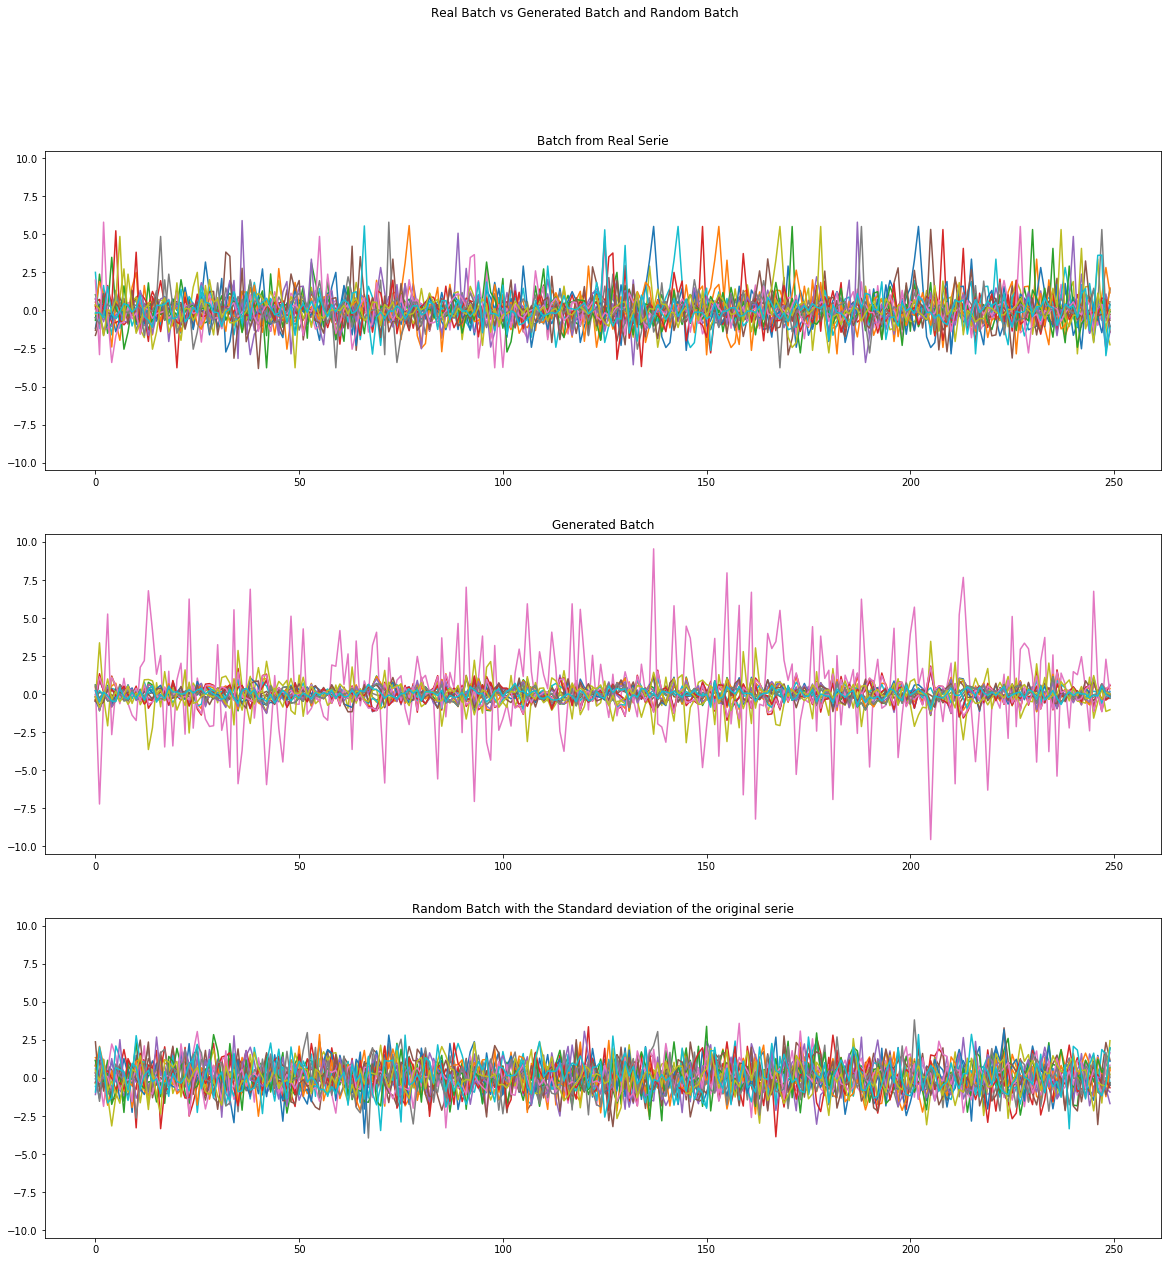

In [215]:
name_best = n2[order_250[1]]
utils.compare_plots(name_best, data, 20, 250, LG, LD)

In [216]:
df = pd.read_csv('VIX.csv', index_col=0, parse_dates=True, dayfirst=True)
df.iloc[:, 0] = df.iloc[:, 0].astype('float')
r = np.log(df).diff()[1:]
dt = [(df.index[t+1]-df.index[t]).days for t in range(r.shape[0])]
r = 1/np.array(dt) * r.iloc[:, 0]

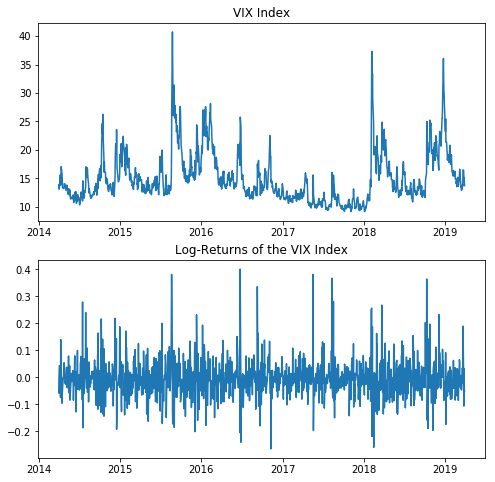

In [217]:
fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(df)
ax[0].set_title('VIX Index')
ax[1].plot(r)
ax[1].set_title('Log-Returns of the VIX Index')
plt.savefig('VIX.png')
plt.show()